# 개요

    1. 태양광 발전량 예측의 필요성 및 어려움
    -전력시스템과 스마트그리드 시스템을 안정적이고 효율적으로 운용 가능
    -태양광발전은 여러 변수의 불확실성 때문에 예측이 쉽지 않다

    2. 태양광 발전량에 영향을 미치는 요인
    - 기상 요인 : 일사량, 일조량, 자외선, 온도, 운량, 강우량, 강설량, 황사, 미세먼지, 상대습도, 풍량, 풍속
    - 지리 요인 : 위도, 경도, 해발 높이
    - 설비 요인 : 모듈의 경사각, 축전지 및 전력 변환장치의 효율
    - 그러나, 모든 영향이 포함된 모델에서 높은 정확도가 얻어지는 것은 아님

    3. 예측의 다양한 방법론
    - 0~6시간 전의 예측 : 토탈 하늘 사진, 구름 이동 벡터 접근, 확률 학습 기법
    - 6시간 전 ~ 며칠 전의 예측 : (가장 많이 사용되는 예측) 수치 날씨 예측 모델(NWP)

    4. 업스케일링
    - 시스템의 일부 자료를 활용해 전체 출력을 예측
    - 단일 발전시스템이 아닌 다수의 태양광 발전의 예측이 필요할 때 사용

    5. Point 예측과 Area 예측 
    - 출력 area : 장치에서 송출해야 할 데이터를 일시적으로 저장해두는 ㅇ장소
    - 업스케일링 기법 사용 : 단일 시스템 예측보다 오류가 낮다
    - 지역의 크기가 클수록, 개별 관측소가 많을수록, 관측소 간 거리가 멀수록 태양광 발전량 예측의 정확도가 올라간다
    - point 예측보다 area 예측의 RMSE가 64% 낮다
    - 캐나다, 미국 10곳의 평균 일사량 예측(area) RMSE가 각각 지상관측소의 일사량 예측(point) RMSE보다 67% 낮다

    6. 정확도 지표
    - RMSE, MAE, MBE

    7. 검증
    - 지리요인, 기상요인 전체 feature 활용 발전량 예측 vs 일부 feature 활용 발전량 예측 : RMSE 값 비교
    - Point 예측(완도 기상데이터) vs Area 예측(완도 기상데이터, 신지도 기상데이터, 등등) : RMSE 값 비교

## 1. 라이브러리 

In [1]:
import pandas as pd
import datetime

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

#ggplot 스타일은 격자로 숫자범위가 나타남
# plt.style.use('ggplot')

#그래프에서 마이너스 폰트가 깨지는 문제 대처
mpl.rcParams['axes.unicode_minus']=False

In [2]:
#한글 폰트 깨짐문제 대처
import platform
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')

## 2. 데이터 로드

In [3]:
solar = pd.read_excel('solar.xls')
wando = pd.read_csv('wando_original.csv', encoding='cp949')
# wando = pd.read_csv('wando.csv', encoding='utf-8')
    

In [4]:
solar.head(1)

,날짜,구분,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,20Hr,충전시간발전량
0,2016-07-01,INV1,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,1.1,7.3,1.5,0.2,0.0,0,140.5


In [5]:
solar.tail(1)

,날짜,구분,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,20Hr,충전시간발전량
381,2017-07-17,INV1,0.0,8.0,81.9,172.7,230.4,178.9,228.4,189.1,195.4,142.2,100.6,57.5,22.3,6.4,0.0,0,1092.1


## 3. 전처리

In [6]:
solar_y = solar[['충전시간발전량']]

In [7]:
solar_y.isnull().sum()

충전시간발전량    0
dtype: int64

In [8]:
wando.head(1)

,지점,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,170,2016-01-01,4.6,-0.4,800,8.8,1423,NaN,NaN,NaN,...,6.7,1027.2,1034.7,1034,1028.7,2400,1031.6,9.9,8.4,-1.7


In [9]:
wando.tail(1)

,지점,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
563,170,2017-07-17,28.1,26.1,2147,30.5,1220,NaN,0.7,1707.0,...,35.7,1008.9,1014.0,2,1011.8,1934,1012.9,14.2,4.1,24.9


In [10]:
# wando['일시'] = pd.to_datetime(wando['일시'])

In [11]:
wando[wando['일시']=='2016-07-01']

,지점,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
182,170,2016-07-01,23.9,21.5,1,26.2,1814,NaN,11.5,1149.0,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3


In [12]:
wando = wando.iloc[182:]

In [13]:
wando.head()

,지점,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
182,170,2016-07-01,23.9,21.5,1,26.2,1814,NaN,11.5,1149.0,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3
183,170,2016-07-02,23.0,21.6,1142,26.0,1,NaN,11.6,1231.0,...,27.8,1002.3,1008.7,2337,1003.8,211,1006.3,14.4,0.4,22.1
184,170,2016-07-03,21.0,20.1,1530,22.9,57,NaN,3.8,2157.0,...,24.5,1005.5,1011.4,856,1008.1,1822,1009.6,14.4,0.0,20.8
185,170,2016-07-04,25.2,21.2,1,29.6,1554,NaN,0.1,NaN,...,31.8,1005.9,1011.6,2331,1008.6,308,1009.9,14.4,2.4,21.7
186,170,2016-07-05,27.6,22.4,249,31.3,1156,NaN,0.1,1459.0,...,35.5,1008.4,1014.0,2305,1011.3,433,1012.4,14.4,8.2,23.3


In [14]:
wando.drop('지점', axis=1, inplace = True)

In [15]:
wando.reset_index(drop=True, inplace=True)

In [16]:
wando.head(1)

,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,2016-07-01,23.9,21.5,1,26.2,1814,NaN,11.5,1149.0,21.1,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3


In [17]:
wando.tail(1)

,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
381,2017-07-17,28.1,26.1,2147,30.5,1220,NaN,0.7,1707.0,0.7,...,35.7,1008.9,1014.0,2,1011.8,1934,1012.9,14.2,4.1,24.9


In [18]:
wando.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 34 columns):
일시                     382 non-null object
평균기온(°C)               382 non-null float64
최저기온(°C)               382 non-null float64
최저기온 시각(hhmi)          382 non-null int64
최고기온(°C)               381 non-null float64
최고기온 시각(hhmi)          382 non-null int64
강수 계속시간(hr)            0 non-null float64
10분 최다 강수량(mm)         89 non-null float64
10분 최다강수량 시각(hhmi)     56 non-null float64
1시간 최다강수량(mm)          89 non-null float64
1시간 최다 강수량 시각(hhmi)    61 non-null float64
일강수량(mm)               158 non-null float64
최대 순간 풍속(m/s)          382 non-null float64
최대 순간 풍속 풍향(16방위)      382 non-null int64
최대 순간풍속 시각(hhmi)       382 non-null int64
최대 풍속(m/s)             382 non-null float64
최대 풍속 풍향(16방위)         382 non-null int64
최대 풍속 시각(hhmi)         382 non-null int64
평균 풍속(m/s)             382 non-null float64
풍정합(100m)              382 non-null int64
평균 이슬점온도(°C)           382 non-null 

In [19]:
wando.head()

,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,2016-07-01,23.9,21.5,1,26.2,1814,NaN,11.5,1149.0,21.1,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3
1,2016-07-02,23.0,21.6,1142,26.0,1,NaN,11.6,1231.0,36.4,...,27.8,1002.3,1008.7,2337,1003.8,211,1006.3,14.4,0.4,22.1
2,2016-07-03,21.0,20.1,1530,22.9,57,NaN,3.8,2157.0,10.6,...,24.5,1005.5,1011.4,856,1008.1,1822,1009.6,14.4,0.0,20.8
3,2016-07-04,25.2,21.2,1,29.6,1554,NaN,0.1,NaN,0.1,...,31.8,1005.9,1011.6,2331,1008.6,308,1009.9,14.4,2.4,21.7
4,2016-07-05,27.6,22.4,249,31.3,1156,NaN,0.1,1459.0,0.1,...,35.5,1008.4,1014.0,2305,1011.3,433,1012.4,14.4,8.2,23.3


In [20]:
wando.isnull().sum()

일시                       0
평균기온(°C)                 0
최저기온(°C)                 0
최저기온 시각(hhmi)            0
최고기온(°C)                 1
최고기온 시각(hhmi)            0
강수 계속시간(hr)            382
10분 최다 강수량(mm)         293
10분 최다강수량 시각(hhmi)     326
1시간 최다강수량(mm)          293
1시간 최다 강수량 시각(hhmi)    321
일강수량(mm)               224
최대 순간 풍속(m/s)            0
최대 순간 풍속 풍향(16방위)        0
최대 순간풍속 시각(hhmi)         0
최대 풍속(m/s)               0
최대 풍속 풍향(16방위)           0
최대 풍속 시각(hhmi)           0
평균 풍속(m/s)               0
풍정합(100m)                0
평균 이슬점온도(°C)             0
최소 상대습도(%)               0
최소 상대습도 시각(hhmi)         0
평균 상대습도(%)               0
평균 증기압(hPa)              0
평균 현지기압(hPa)             0
최고 해면기압(hPa)             0
최고 해면기압 시각(hhmi)         0
최저 해면기압(hPa)             0
최저 해면기압 시각(hhmi)         0
평균 해면기압(hPa)             0
가조시간(hr)                 0
합계 일조 시간(hr)             0
최저 초상온도(°C)              0
dtype: int64

    강수 계속시간(hr)            382
    10분 최다 강수량(mm)         293
    10분 최다강수량 시각(hhmi)     326
    1시간 최다강수량(mm)          293
    1시간 최다 강수량 시각(hhmi)    321
    날리기. 데이터가 너무 적다.
    
    반면, 일강수량(mm)               224
    일강수량의 nan값은 0 으로

### [3-2]Null 값 인덱스 찾기

In [21]:
wando[wando['최고기온(°C)'].isnull()].index

Int64Index([175], dtype='int64')

In [22]:
wando['최고기온(°C)'][170:180]

170    12.1
171    11.4
172    14.2
173    20.2
174    20.2
175     NaN
176     6.8
177     9.9
178     9.3
179     6.5
Name: 최고기온(°C), dtype: float64

In [23]:
wando['최고기온(°C)'][175] = 13.5

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### [3-3] Null 값 모두 나타내기

In [24]:
wando[wando.isnull().any(axis=1)] 

,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,2016-07-01,23.9,21.5,1,26.2,1814,NaN,11.5,1149.0,21.1,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3
1,2016-07-02,23.0,21.6,1142,26.0,1,NaN,11.6,1231.0,36.4,...,27.8,1002.3,1008.7,2337,1003.8,211,1006.3,14.4,0.4,22.1
2,2016-07-03,21.0,20.1,1530,22.9,57,NaN,3.8,2157.0,10.6,...,24.5,1005.5,1011.4,856,1008.1,1822,1009.6,14.4,0.0,20.8
3,2016-07-04,25.2,21.2,1,29.6,1554,NaN,0.1,NaN,0.1,...,31.8,1005.9,1011.6,2331,1008.6,308,1009.9,14.4,2.4,21.7
4,2016-07-05,27.6,22.4,249,31.3,1156,NaN,0.1,1459.0,0.1,...,35.5,1008.4,1014.0,2305,1011.3,433,1012.4,14.4,8.2,23.3
5,2016-07-06,27.3,24.3,2341,30.9,1335,NaN,0.4,313.0,0.5,...,35.6,1010.7,1015.6,2304,1013.5,47,1014.7,14.4,8.0,25.4
6,2016-07-07,25.2,22.6,611,29.3,1351,NaN,0.2,NaN,0.2,...,31.6,1010.2,1015.7,2,1012.9,1820,1014.2,14.4,10.5,24.6
7,2016-07-08,25.8,22.6,307,29.7,1431,NaN,0.0,NaN,0.0,...,31.1,1005.4,1012.9,1,1006.7,1910,1009.4,14.3,10.6,24.2
8,2016-07-09,25.5,22.1,315,30.4,1521,NaN,NaN,NaN,NaN,...,31.6,1002.5,1007.9,1,1005.3,1653,1006.5,14.3,11.4,23.5
9,2016-07-10,24.5,22.6,423,26.7,1451,NaN,NaN,NaN,NaN,...,30.3,1000.8,1006.1,2,1003.6,1441,1004.8,14.3,0.0,24.4


### [3-4] 결측치 처리 : fillna

강수량 nan 값은 0mm 이었음. 따라서 fillna(0)

In [25]:
wando['일강수량(mm)'] = wando['일강수량(mm)'].fillna(0)

In [26]:
wando.head()

,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,2016-07-01,23.9,21.5,1,26.2,1814,NaN,11.5,1149.0,21.1,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3
1,2016-07-02,23.0,21.6,1142,26.0,1,NaN,11.6,1231.0,36.4,...,27.8,1002.3,1008.7,2337,1003.8,211,1006.3,14.4,0.4,22.1
2,2016-07-03,21.0,20.1,1530,22.9,57,NaN,3.8,2157.0,10.6,...,24.5,1005.5,1011.4,856,1008.1,1822,1009.6,14.4,0.0,20.8
3,2016-07-04,25.2,21.2,1,29.6,1554,NaN,0.1,NaN,0.1,...,31.8,1005.9,1011.6,2331,1008.6,308,1009.9,14.4,2.4,21.7
4,2016-07-05,27.6,22.4,249,31.3,1156,NaN,0.1,1459.0,0.1,...,35.5,1008.4,1014.0,2305,1011.3,433,1012.4,14.4,8.2,23.3


    강수 계속시간(hr)            382
    10분 최다 강수량(mm)         293
    10분 최다강수량 시각(hhmi)     326
    1시간 최다강수량(mm)          293
    1시간 최다 강수량 시각(hhmi)    321
    날리기. 데이터가 너무 적다.

In [27]:
wando.columns

Index(['일시', '평균기온(°C)', '최저기온(°C)', '최저기온 시각(hhmi)', '최고기온(°C)',
       '최고기온 시각(hhmi)', '강수 계속시간(hr)', '10분 최다 강수량(mm)', '10분 최다강수량 시각(hhmi)',
       '1시간 최다강수량(mm)', '1시간 최다 강수량 시각(hhmi)', '일강수량(mm)', '최대 순간 풍속(m/s)',
       '최대 순간 풍속 풍향(16방위)', '최대 순간풍속 시각(hhmi)', '최대 풍속(m/s)', '최대 풍속 풍향(16방위)',
       '최대 풍속 시각(hhmi)', '평균 풍속(m/s)', '풍정합(100m)', '평균 이슬점온도(°C)',
       '최소 상대습도(%)', '최소 상대습도 시각(hhmi)', '평균 상대습도(%)', '평균 증기압(hPa)',
       '평균 현지기압(hPa)', '최고 해면기압(hPa)', '최고 해면기압 시각(hhmi)', '최저 해면기압(hPa)',
       '최저 해면기압 시각(hhmi)', '평균 해면기압(hPa)', '가조시간(hr)', '합계 일조 시간(hr)',
       '최저 초상온도(°C)'],
      dtype='object')

In [28]:
wando.drop(['일시','강수 계속시간(hr)', '10분 최다 강수량(mm)', '10분 최다강수량 시각(hhmi)','1시간 최다강수량(mm)', '1시간 최다 강수량 시각(hhmi)'], axis =1, inplace=True)

In [29]:
wando.columns

Index(['평균기온(°C)', '최저기온(°C)', '최저기온 시각(hhmi)', '최고기온(°C)', '최고기온 시각(hhmi)',
       '일강수량(mm)', '최대 순간 풍속(m/s)', '최대 순간 풍속 풍향(16방위)', '최대 순간풍속 시각(hhmi)',
       '최대 풍속(m/s)', '최대 풍속 풍향(16방위)', '최대 풍속 시각(hhmi)', '평균 풍속(m/s)',
       '풍정합(100m)', '평균 이슬점온도(°C)', '최소 상대습도(%)', '최소 상대습도 시각(hhmi)',
       '평균 상대습도(%)', '평균 증기압(hPa)', '평균 현지기압(hPa)', '최고 해면기압(hPa)',
       '최고 해면기압 시각(hhmi)', '최저 해면기압(hPa)', '최저 해면기압 시각(hhmi)', '평균 해면기압(hPa)',
       '가조시간(hr)', '합계 일조 시간(hr)', '최저 초상온도(°C)'],
      dtype='object')

In [30]:
wando.head(2)

,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,23.9,21.5,1,26.2,1814,51.2,15.7,160,2353,9.2,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3
1,23.0,21.6,1142,26.0,1,55.7,21.5,180,226,10.4,...,27.8,1002.3,1008.7,2337,1003.8,211,1006.3,14.4,0.4,22.1


In [31]:
wando.head()

,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,23.9,21.5,1,26.2,1814,51.2,15.7,160,2353,9.2,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3
1,23.0,21.6,1142,26.0,1,55.7,21.5,180,226,10.4,...,27.8,1002.3,1008.7,2337,1003.8,211,1006.3,14.4,0.4,22.1
2,21.0,20.1,1530,22.9,57,44.9,6.9,70,1623,5.2,...,24.5,1005.5,1011.4,856,1008.1,1822,1009.6,14.4,0.0,20.8
3,25.2,21.2,1,29.6,1554,0.4,11.3,90,1902,6.0,...,31.8,1005.9,1011.6,2331,1008.6,308,1009.9,14.4,2.4,21.7
4,27.6,22.4,249,31.3,1156,0.1,11.8,110,1010,6.6,...,35.5,1008.4,1014.0,2305,1011.3,433,1012.4,14.4,8.2,23.3


In [32]:
len(wando)

382

In [33]:
len(solar_y)

382

In [34]:
wando.head()

,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,23.9,21.5,1,26.2,1814,51.2,15.7,160,2353,9.2,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3
1,23.0,21.6,1142,26.0,1,55.7,21.5,180,226,10.4,...,27.8,1002.3,1008.7,2337,1003.8,211,1006.3,14.4,0.4,22.1
2,21.0,20.1,1530,22.9,57,44.9,6.9,70,1623,5.2,...,24.5,1005.5,1011.4,856,1008.1,1822,1009.6,14.4,0.0,20.8
3,25.2,21.2,1,29.6,1554,0.4,11.3,90,1902,6.0,...,31.8,1005.9,1011.6,2331,1008.6,308,1009.9,14.4,2.4,21.7
4,27.6,22.4,249,31.3,1156,0.1,11.8,110,1010,6.6,...,35.5,1008.4,1014.0,2305,1011.3,433,1012.4,14.4,8.2,23.3


In [35]:
wando.reset_index(drop = True).head()

,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,23.9,21.5,1,26.2,1814,51.2,15.7,160,2353,9.2,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3
1,23.0,21.6,1142,26.0,1,55.7,21.5,180,226,10.4,...,27.8,1002.3,1008.7,2337,1003.8,211,1006.3,14.4,0.4,22.1
2,21.0,20.1,1530,22.9,57,44.9,6.9,70,1623,5.2,...,24.5,1005.5,1011.4,856,1008.1,1822,1009.6,14.4,0.0,20.8
3,25.2,21.2,1,29.6,1554,0.4,11.3,90,1902,6.0,...,31.8,1005.9,1011.6,2331,1008.6,308,1009.9,14.4,2.4,21.7
4,27.6,22.4,249,31.3,1156,0.1,11.8,110,1010,6.6,...,35.5,1008.4,1014.0,2305,1011.3,433,1012.4,14.4,8.2,23.3


### + 이상치 확인

나눠서 plot ! 

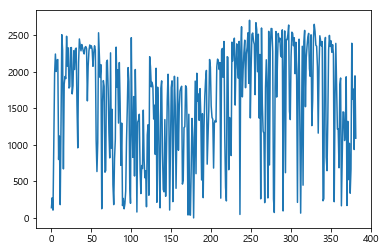

In [36]:
solar_y['충전시간발전량'].plot()

In [37]:
wando.columns

Index(['평균기온(°C)', '최저기온(°C)', '최저기온 시각(hhmi)', '최고기온(°C)', '최고기온 시각(hhmi)',
       '일강수량(mm)', '최대 순간 풍속(m/s)', '최대 순간 풍속 풍향(16방위)', '최대 순간풍속 시각(hhmi)',
       '최대 풍속(m/s)', '최대 풍속 풍향(16방위)', '최대 풍속 시각(hhmi)', '평균 풍속(m/s)',
       '풍정합(100m)', '평균 이슬점온도(°C)', '최소 상대습도(%)', '최소 상대습도 시각(hhmi)',
       '평균 상대습도(%)', '평균 증기압(hPa)', '평균 현지기압(hPa)', '최고 해면기압(hPa)',
       '최고 해면기압 시각(hhmi)', '최저 해면기압(hPa)', '최저 해면기압 시각(hhmi)', '평균 해면기압(hPa)',
       '가조시간(hr)', '합계 일조 시간(hr)', '최저 초상온도(°C)'],
      dtype='object')

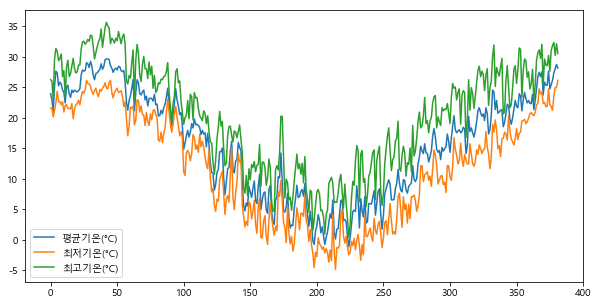

In [38]:
wando[['평균기온(°C)', '최저기온(°C)', '최고기온(°C)']].plot(figsize=(10,5))

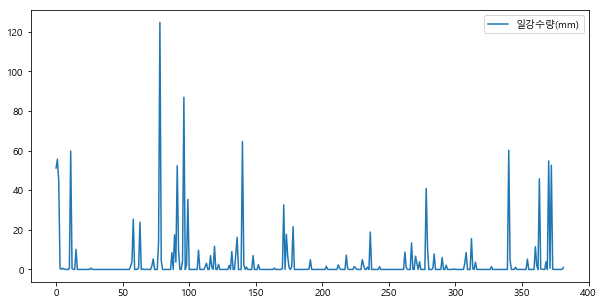

In [39]:
wando[['일강수량(mm)']].plot(figsize=(10,5))

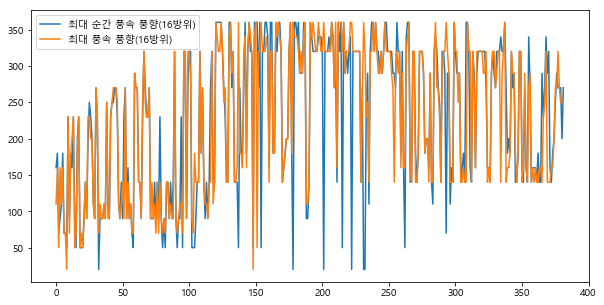

In [40]:
wando[['최대 순간 풍속 풍향(16방위)','최대 풍속 풍향(16방위)']].plot(figsize=(10,5))

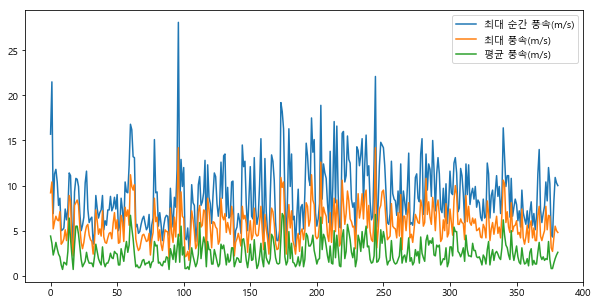

In [41]:
wando[['최대 순간 풍속(m/s)', '최대 풍속(m/s)','평균 풍속(m/s)']].plot(figsize=(10,5))

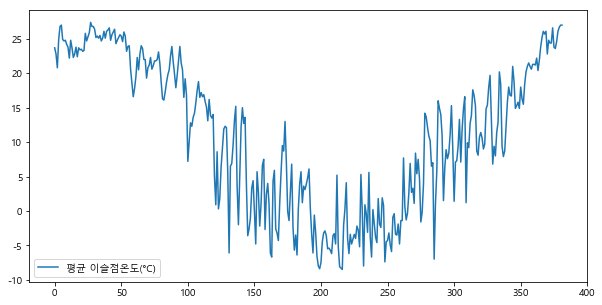

In [42]:
wando[['평균 이슬점온도(°C)']].plot(figsize=(10,5))

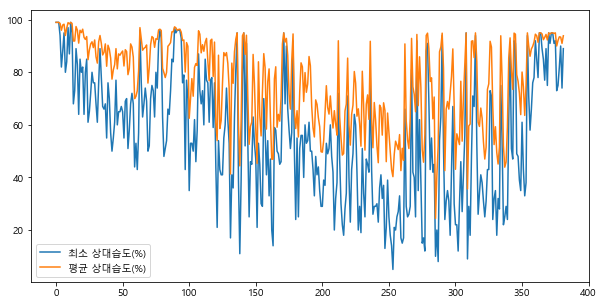

In [43]:
wando[['최소 상대습도(%)','평균 상대습도(%)']].plot(figsize=(10,5))

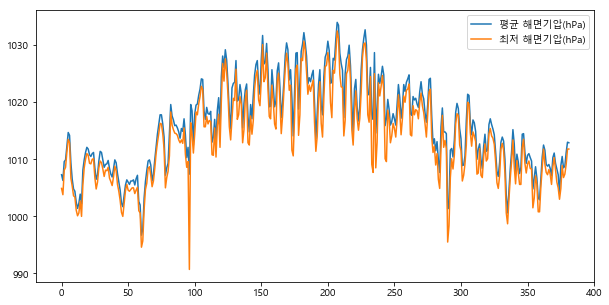

In [44]:
wando[['평균 해면기압(hPa)', '최저 해면기압(hPa)']].plot(figsize=(10,5))

In [45]:
len(solar_y), len(wando)

(382, 382)

In [46]:
# 상관관계가 있으니, point 플랏은 의미없음

### [3-6] CSV 저장하기

In [47]:
wando.to_csv('완도기상데이터 전처리.csv', index = False)

In [48]:
wando.head()

,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,23.9,21.5,1,26.2,1814,51.2,15.7,160,2353,9.2,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3
1,23.0,21.6,1142,26.0,1,55.7,21.5,180,226,10.4,...,27.8,1002.3,1008.7,2337,1003.8,211,1006.3,14.4,0.4,22.1
2,21.0,20.1,1530,22.9,57,44.9,6.9,70,1623,5.2,...,24.5,1005.5,1011.4,856,1008.1,1822,1009.6,14.4,0.0,20.8
3,25.2,21.2,1,29.6,1554,0.4,11.3,90,1902,6.0,...,31.8,1005.9,1011.6,2331,1008.6,308,1009.9,14.4,2.4,21.7
4,27.6,22.4,249,31.3,1156,0.1,11.8,110,1010,6.6,...,35.5,1008.4,1014.0,2305,1011.3,433,1012.4,14.4,8.2,23.3


### 중간결론

1. 회귀 분석을 할 때 '시각' 데이터는 필요 없어 보임
2. 비슷한 feature 많다 - 다중공선성 문제 가능 -> VIF검사 후 feature 줄이기

In [49]:
wando.head(1)

,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),...,평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,23.9,21.5,1,26.2,1814,51.2,15.7,160,2353,9.2,...,29.4,1003.3,1011.6,1,1004.9,2021,1007.3,14.4,0.0,22.3


In [50]:
wando.columns

Index(['평균기온(°C)', '최저기온(°C)', '최저기온 시각(hhmi)', '최고기온(°C)', '최고기온 시각(hhmi)',
       '일강수량(mm)', '최대 순간 풍속(m/s)', '최대 순간 풍속 풍향(16방위)', '최대 순간풍속 시각(hhmi)',
       '최대 풍속(m/s)', '최대 풍속 풍향(16방위)', '최대 풍속 시각(hhmi)', '평균 풍속(m/s)',
       '풍정합(100m)', '평균 이슬점온도(°C)', '최소 상대습도(%)', '최소 상대습도 시각(hhmi)',
       '평균 상대습도(%)', '평균 증기압(hPa)', '평균 현지기압(hPa)', '최고 해면기압(hPa)',
       '최고 해면기압 시각(hhmi)', '최저 해면기압(hPa)', '최저 해면기압 시각(hhmi)', '평균 해면기압(hPa)',
       '가조시간(hr)', '합계 일조 시간(hr)', '최저 초상온도(°C)'],
      dtype='object')

wando2 : 시간 데이터 삭제

In [51]:
wando_new = wando[['평균기온(°C)', '최저기온(°C)','최고기온(°C)', '일강수량(mm)', '최대 순간 풍속(m/s)', '최대 순간 풍속 풍향(16방위)',
    '최대 풍속(m/s)', '최대 풍속 풍향(16방위)', '평균 풍속(m/s)',
       '풍정합(100m)', '평균 이슬점온도(°C)', '최소 상대습도(%)',
       '평균 상대습도(%)', '평균 증기압(hPa)', '평균 현지기압(hPa)', '최고 해면기압(hPa)',
       '최저 해면기압(hPa)', '평균 해면기압(hPa)', '가조시간(hr)', '합계 일조 시간(hr)', '최저 초상온도(°C)']]

### [3-7] 전처리 파일 저장

In [56]:
wando_new.to_csv('완도기상데이터 전처리(new).csv', index = False)

## 4. 시각화

In [57]:
corrMatt = wando_new.corr()

In [58]:
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False # 이건 무슨 뜻일까?

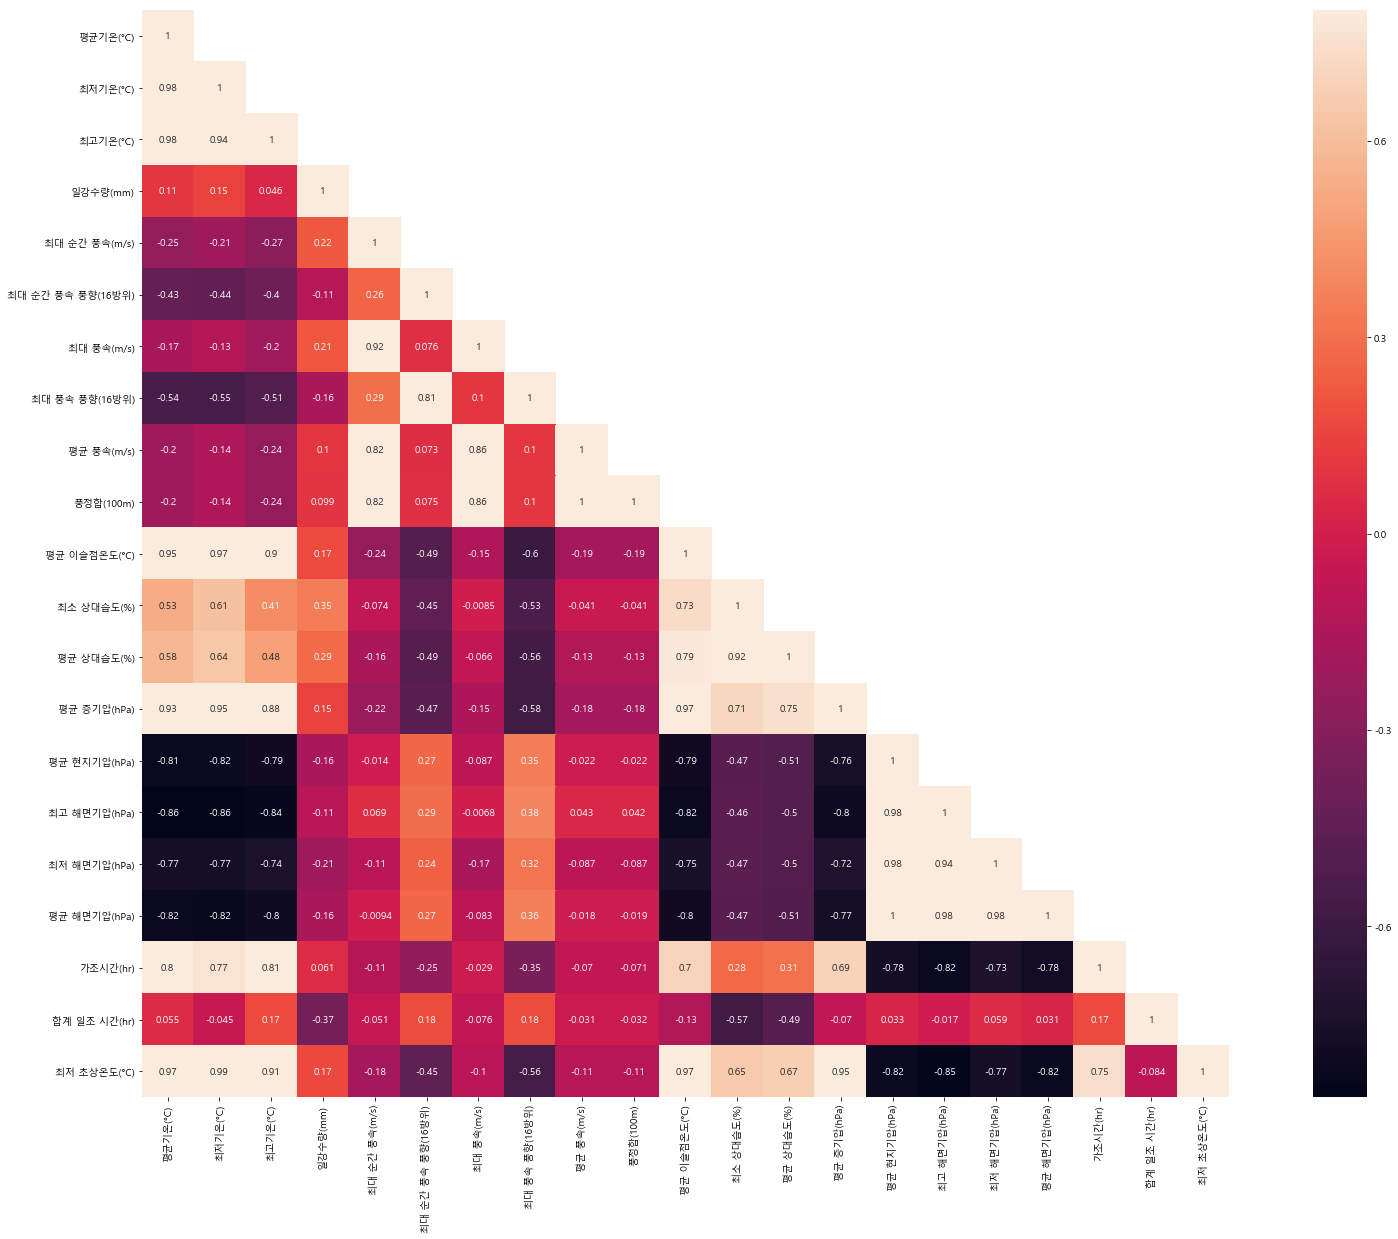

In [59]:
fig, ax= plt.subplots(figsize = (35,25))
fig.set_size_inches(30,20)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split

In [61]:
len(wando_new)

382

In [62]:
len(solar_y)

382

In [63]:
382 * 0.75

286.5

In [64]:
X_train = wando_new[0:286]
X_test = wando_new[286:]
y_train = solar_y[0:286]
y_test = solar_y[286:]

In [65]:
wando_new.head()

,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 풍속(m/s),최대 풍속 풍향(16방위),평균 풍속(m/s),풍정합(100m),...,최소 상대습도(%),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최저 해면기압(hPa),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,23.9,21.5,26.2,51.2,15.7,160,9.2,110,4.4,3813,...,99,99.0,29.4,1003.3,1011.6,1004.9,1007.3,14.4,0.0,22.3
1,23.0,21.6,26.0,55.7,21.5,180,10.4,160,3.6,3134,...,99,99.0,27.8,1002.3,1008.7,1003.8,1006.3,14.4,0.4,22.1
2,21.0,20.1,22.9,44.9,6.9,70,5.2,50,2.3,1973,...,99,99.0,24.5,1005.5,1011.4,1008.1,1009.6,14.4,0.0,20.8
3,25.2,21.2,29.6,0.4,11.3,90,6.0,160,2.9,2471,...,94,98.6,31.8,1005.9,1011.6,1008.6,1009.9,14.4,2.4,21.7
4,27.6,22.4,31.3,0.1,11.8,110,6.6,110,3.7,3169,...,82,96.0,35.5,1008.4,1014.0,1011.3,1012.4,14.4,8.2,23.3


In [66]:
# X_train, X_test, y_train, y_test = train_test_split(wando, solar_y , test_size=0.25, random_state=42)

In [67]:
X_train.head()

,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 풍속(m/s),최대 풍속 풍향(16방위),평균 풍속(m/s),풍정합(100m),...,최소 상대습도(%),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최저 해면기압(hPa),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,23.9,21.5,26.2,51.2,15.7,160,9.2,110,4.4,3813,...,99,99.0,29.4,1003.3,1011.6,1004.9,1007.3,14.4,0.0,22.3
1,23.0,21.6,26.0,55.7,21.5,180,10.4,160,3.6,3134,...,99,99.0,27.8,1002.3,1008.7,1003.8,1006.3,14.4,0.4,22.1
2,21.0,20.1,22.9,44.9,6.9,70,5.2,50,2.3,1973,...,99,99.0,24.5,1005.5,1011.4,1008.1,1009.6,14.4,0.0,20.8
3,25.2,21.2,29.6,0.4,11.3,90,6.0,160,2.9,2471,...,94,98.6,31.8,1005.9,1011.6,1008.6,1009.9,14.4,2.4,21.7
4,27.6,22.4,31.3,0.1,11.8,110,6.6,110,3.7,3169,...,82,96.0,35.5,1008.4,1014.0,1011.3,1012.4,14.4,8.2,23.3


In [68]:
from statsmodels.datasets.longley import load_pandas
wando_new.head(1)

,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 풍속(m/s),최대 풍속 풍향(16방위),평균 풍속(m/s),풍정합(100m),...,최소 상대습도(%),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최저 해면기압(hPa),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C)
0,23.9,21.5,26.2,51.2,15.7,160,9.2,110,4.4,3813,...,99,99.0,29.4,1003.3,1011.6,1004.9,1007.3,14.4,0.0,22.3


In [69]:
solar_y.head(1)

,충전시간발전량
0,140.5


In [70]:
data = wando_new.copy()
data['발전량'] = solar_y

In [71]:
data.head()

,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 풍속(m/s),최대 풍속 풍향(16방위),평균 풍속(m/s),풍정합(100m),...,평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최저 해면기압(hPa),평균 해면기압(hPa),가조시간(hr),합계 일조 시간(hr),최저 초상온도(°C),발전량
0,23.9,21.5,26.2,51.2,15.7,160,9.2,110,4.4,3813,...,99.0,29.4,1003.3,1011.6,1004.9,1007.3,14.4,0.0,22.3,140.5
1,23.0,21.6,26.0,55.7,21.5,180,10.4,160,3.6,3134,...,99.0,27.8,1002.3,1008.7,1003.8,1006.3,14.4,0.4,22.1,276.8
2,21.0,20.1,22.9,44.9,6.9,70,5.2,50,2.3,1973,...,99.0,24.5,1005.5,1011.4,1008.1,1009.6,14.4,0.0,20.8,107.8
3,25.2,21.2,29.6,0.4,11.3,90,6.0,160,2.9,2471,...,98.6,31.8,1005.9,1011.6,1008.6,1009.9,14.4,2.4,21.7,1012.9
4,27.6,22.4,31.3,0.1,11.8,110,6.6,110,3.7,3169,...,96.0,35.5,1008.4,1014.0,1011.3,1012.4,14.4,8.2,23.3,1975.6


## 5. Feature Engineering

### [5-1] 다중공선성 확인 

https://datascienceschool.net/view-notebook/36176e580d124612a376cf29872cd2f0/

VIF 가장 높은 feature 하나 줄이고 - 결과(RMSE) 확인 - VIF 확인 - 결과(RMSE) 확인- ... - 퍼포먼스가 떨어지기 전까지만!

실생활에 적용할 때, 적은 feature로 Y값을 예측하는 게 효율적임
- 복잡한 모델일수록 안좋다.
- 데이터 양이 늘어나면 시간도 오래걸리니까!
- 또한 feature 개수가 많으면 과적합 될 수 있다. 즉, 예측이 잘 안될 수 있다.

상관관계 시각화(수치가 아닌 그림)

In [72]:
# sns.pairplot(data)
# plt.show()

### feature drop할 때마다 공선성도 다시 renew 해야한다!

feature 줄어들 때마다 공선성의 정도가 달라짐!

In [347]:
wando_new2 = wando_new.copy() # VIF 제거 전 Original 활용
solar_y2 = solar_y.copy()

wando_new3 = wando_new.copy() # VIF 1개 제거
solar_y3 = solar_y.copy()

wando_new4 = wando_new.copy() # VIF 2개 제거
solar_y4 = solar_y.copy()

wando_new5 = wando_new.copy() # VIF 3개 제거
solar_y5 = solar_y.copy()

wando_new6 = wando_new.copy() # VIF 4개 제거
solar_y6 = solar_y.copy()

wando_new7 = wando_new.copy() # VIF 5개 제거
solar_y7 = solar_y.copy()

wando_new8 = wando_new.copy() # VIF 6개 제거
solar_y8 = solar_y.copy()

In [348]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    wando_new7.values, i) for i in range(wando_new7.shape[1])]
vif["features"] = wando_new7.columns
vif.head(3)

,VIF Factor,features
0,3057.392758,평균기온(°C)
1,550.966527,최저기온(°C)
2,534.952853,최고기온(°C)


VIF 내림차순 정렬

In [349]:
wando_new.columns

Index(['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 순간 풍속(m/s)',
       '최대 순간 풍속 풍향(16방위)', '최대 풍속(m/s)', '최대 풍속 풍향(16방위)', '평균 풍속(m/s)',
       '풍정합(100m)', '평균 이슬점온도(°C)', '최소 상대습도(%)', '평균 상대습도(%)', '평균 증기압(hPa)',
       '평균 현지기압(hPa)', '최고 해면기압(hPa)', '최저 해면기압(hPa)', '평균 해면기압(hPa)',
       '가조시간(hr)', '합계 일조 시간(hr)', '최저 초상온도(°C)'],
      dtype='object')

In [350]:
vif.sort_values(by=['VIF Factor'], ascending = False)

,VIF Factor,features
14,6.223262e+08,평균 현지기압(hPa)
17,6.179044e+08,평균 해면기압(hPa)
16,1.697105e+06,최저 해면기압(hPa)
15,1.507363e+06,최고 해면기압(hPa)
8,1.047252e+04,평균 풍속(m/s)
9,1.046719e+04,풍정합(100m)
0,3.057393e+03,평균기온(°C)
12,2.310027e+03,평균 상대습도(%)
10,1.501627e+03,평균 이슬점온도(°C)
1,5.509665e+02,최저기온(°C)


### [5-1-1] featur 1개 drop

In [351]:
wando_new3.drop(['평균 현지기압(hPa)'],axis=1, inplace=True) 

### [5-1-2] feature 2개 drop

In [352]:
wando_new4.drop(['평균 현지기압(hPa)', '평균 해면기압(hPa)'],axis=1, inplace=True) 

### [5-1-3] feature 3개 drop

In [353]:
wando_new5.drop(['평균 현지기압(hPa)', '평균 해면기압(hPa)', '평균 현지기압(hPa)'] ,axis=1, inplace=True)

### 4개 드랍

In [354]:
wando_new6.drop(['평균 현지기압(hPa)', '평균 해면기압(hPa)', '평균 현지기압(hPa)', '최저 해면기압(hPa)'] ,axis=1, inplace=True)

### 5개드랍

In [355]:
wando_new7.drop(['평균 현지기압(hPa)', '평균 해면기압(hPa)', '평균 현지기압(hPa)', '최저 해면기압(hPa)', '평균 풍속(m/s)'] ,axis=1, inplace=True)

### 8개 드랍

In [356]:
wando_new.columns

Index(['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 순간 풍속(m/s)',
       '최대 순간 풍속 풍향(16방위)', '최대 풍속(m/s)', '최대 풍속 풍향(16방위)', '평균 풍속(m/s)',
       '풍정합(100m)', '평균 이슬점온도(°C)', '최소 상대습도(%)', '평균 상대습도(%)', '평균 증기압(hPa)',
       '평균 현지기압(hPa)', '최고 해면기압(hPa)', '최저 해면기압(hPa)', '평균 해면기압(hPa)',
       '가조시간(hr)', '합계 일조 시간(hr)', '최저 초상온도(°C)'],
      dtype='object')

In [357]:
wando_new8.drop(['평균 현지기압(hPa)', '평균 해면기압(hPa)', '평균 현지기압(hPa)', '최저 해면기압(hPa)', '평균 풍속(m/s)','평균기온(°C)', '최고 해면기압(hPa)', '평균 상대습도(%)'] ,axis=1, inplace=True)

In [344]:
# wando2.drop(['최저 해면기압(hPa)'],axis=1, inplace=True) # RMSE 변화 0.1047 - 0.1042

In [289]:
# wando2.drop(['최고 해면기압(hPa)'],axis=1, inplace=True) # RMSE 변화 0.1042 - 0.1042

In [290]:
# wando2.drop(['풍정합(100m)'],axis=1, inplace=True) # RMSE 변화 0.1042 - 0.1041

In [291]:
# wando2.drop(['평균 풍속(m/s)'],axis=1, inplace=True) # RMSE 변화 0.1041- 0.1022


셋분리 - DF value빼놓기 - 스케일 - //모델돌린 후 예측값과 test값 비교하는 DF 만들기

### [5-2] 셋 분리

반복되니까 ! 함수만들어서 쓰자

In [292]:
# def result_f(wando, solar):
#     X_train = 
    

In [359]:
X_train = wando_new2[0:286] #VIF 제거 전
X_test = wando_new2[286:]
y_train = solar_y2[0:286]
y_test = solar_y2[286:]


X_train2 = wando_new3[0:286] #VIF 1개 제거 후
X_test2 = wando_new3[286:]
y_train2 = solar_y3[0:286]
y_test2 = solar_y3[286:]

X_train3 = wando_new4[0:286] #VIF 2개 제거 후
X_test3 = wando_new4[286:]
y_train3 = solar_y4[0:286]
y_test3 = solar_y4[286:]


X_train4 = wando_new5[0:286] #VIF 3개 제거 후
X_test4 = wando_new5[286:]
y_train4 = solar_y5[0:286]
y_test4 = solar_y5[286:]

X_train5 = wando_new6[0:286] #VIF 4개 제거 후
X_test5 = wando_new6[286:]
y_train5 = solar_y6[0:286]
y_test5 = solar_y6[286:]

X_train6 = wando_new7[0:286] #VIF 5개 제거 후
X_test6 = wando_new7[286:]
y_train6 = solar_y7[0:286]
y_test6 = solar_y7[286:]

X_train7 = wando_new8[0:286] #VIF 8개 제거 후
X_test7 = wando_new8[286:]
y_train7 = solar_y8[0:286]
y_test7 = solar_y8[286:]



# X_train2 = wando_new3[0:286] #VIF 1개 제거 후
# X_test2 = wando_new3[286:]
# y_train2 = solar_y3[0:286]
# y_test2 = solar_y3[286:]

# X_train2 = wando_new3[0:286] #VIF 1개 제거 후
# X_test2 = wando_new3[286:]
# y_train2 = solar_y3[0:286]
# y_test2 = solar_y3[286:]

### [5-3] 값만 빼놓기 - train, test index 불일치 해소

In [360]:
X_train_v = X_train.values
X_test_v = X_test.values
y_train_v = y_train.values
y_test_v = y_test.values


X_train2_v = X_train2.values
X_test2_v = X_test2.values
y_train2_v = y_train2.values
y_test2_v = y_test2.values

### [5-4] 스케일

In [381]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
scaler4 = MinMaxScaler()
scaler5 = MinMaxScaler()
scaler6 = MinMaxScaler()
scaler7 = MinMaxScaler()
scaler8 = MinMaxScaler()

In [382]:
X_train = scaler.fit_transform(X_train) # VIF 제거 전 Original
X_test = scaler.transform(X_test) # VIF 제거 전 Original

X_train2 = scaler2.fit_transform(X_train2) # '평균 현지기압(hPa)' 제거 후
X_test2 = scaler2.transform(X_test2) # '평균 현지기압(hPa)' 제거 후

X_train3 = scaler3.fit_transform(X_train3) # VIF 2
X_test3 = scaler3.transform(X_test3) # VIF 2

X_train4 = scaler4.fit_transform(X_train4) # VIF 3
X_test4 = scaler4.transform(X_test4) # VIF 3

X_train5 = scaler5.fit_transform(X_train5) # VIF 4
X_test5 = scaler5.transform(X_test5) # VIF 4

X_train6 = scaler6.fit_transform(X_train6) # VIF 5
X_test6 = scaler6.transform(X_test6) # VIF 5

X_train7 = scaler7.fit_transform(X_train7) # VIF 8
X_test7 = scaler7.transform(X_test7) # VIF 8

In [383]:
y_train = scaler.fit_transform(y_train) # VIF 제거 전 Original
y_test = scaler.transform(y_test) # VIF 제거 전 Original

y_train2 = scaler2.fit_transform(y_train2) # '평균 현지기압(hPa)' 제거 후
y_test2 = scaler2.transform(y_test2)

y_train3 = scaler3.fit_transform(y_train3) # 2
y_test3 = scaler3.transform(y_test3)

y_train4 = scaler4.fit_transform(y_train4) # 3
y_test4 = scaler4.transform(y_test4)

y_train5 = scaler5.fit_transform(y_train5) # 4
y_test5 = scaler5.transform(y_test5)

y_train6 = scaler6.fit_transform(y_train6) # 5
y_test6 = scaler6.transform(y_test6)

y_train7 = scaler7.fit_transform(y_train7) # 5
y_test7 = scaler7.transform(y_test7)

## 6. 모델링

### [6-1] 선형회귀

train_test split 해서 index 마구마구 섞여있음 - 인덱스 정렬 필요

In [384]:
# X_train.sort_index(inplace=True)
# X_test.sort_index(inplace=True)
# y_train.sort_index(inplace=True)
# y_test.sort_index(inplace=True)

In [385]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model2 = LinearRegression(fit_intercept=True)
model3 = LinearRegression(fit_intercept=True)
model4 = LinearRegression(fit_intercept=True)
model5 = LinearRegression(fit_intercept=True)
model6 = LinearRegression(fit_intercept=True)
model7 = LinearRegression(fit_intercept=True)

In [386]:
model = model.fit(X_train, y_train)
model2 = model2.fit(X_train2, y_train2)
model3 = model3.fit(X_train3, y_train3)
model4 = model4.fit(X_train4, y_train4)
model5 = model5.fit(X_train5, y_train5)
model6 = model6.fit(X_train6, y_train6)
model7 = model7.fit(X_train7, y_train7)

In [387]:
y_pred = model.predict(X_test)
y_pred[0:5]
y_pred2 = model2.predict(X_test2)
y_pred3 = model3.predict(X_test3)
y_pred4 = model4.predict(X_test4)
y_pred5 = model5.predict(X_test5)
y_pred6 = model6.predict(X_test6)
y_pred7 = model7.predict(X_test7)




#y_pred_r = scaler.inverse_transform(y_pred) # 스케일한 경우 원래값 복원

#y_pred_r

In [388]:
len(y_test), len(y_pred)

(96, 96)

In [389]:
from sklearn.metrics import mean_squared_error
from math import sqrt

### 7. 결과 확인

In [405]:
def rmsle(predicted_values, actual_values, convertExp=True):
    
    if convertExp:
        predicted_values = np.exp(predicted_values) - 1
        actual_values = np.exp(actual_values) - 1
    
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = (log_predict - log_actual)**2
    
    mean_difference = np.average(difference)
    
    score = np.sqrt(mean_difference)
    
    return score

### [7-1] 모든 feature RMSE :  0.10157566491865322 


In [406]:
mean_squared_error(y_test, y_pred)

0.010312838402587442

In [407]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.10155214622344248

In [409]:
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_test),np.exp(y_pred),False), '\n\n')

RMSLE Value For Ridge Regression:  0.06590047172420123 




### [7-2] VIF 1개 드랍 RMSE :  0.10157566491865372

In [392]:
mean_squared_error(y_test2, y_pred2)

0.01031389052956164

In [393]:
rmse = sqrt(mean_squared_error(y_test2, y_pred2))
rmse

0.10155732632145079

In [410]:
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_test2),np.exp(y_pred2),False), '\n\n')

RMSLE Value For Ridge Regression:  0.0931664769713344 




### [7-3] 2개 드랍

In [394]:
mean_squared_error(y_test3, y_pred3)

0.01072552253925215

In [395]:
rmse = sqrt(mean_squared_error(y_test3, y_pred3))
rmse

0.10356409869859415

In [411]:
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_test3),np.exp(y_pred3),False), '\n\n')

RMSLE Value For Ridge Regression:  0.06700895826150036 




### [7-4] 3개

In [396]:
mean_squared_error(y_test4, y_pred4)

0.01072552253925215

In [397]:
rmse = sqrt(mean_squared_error(y_test4, y_pred4))
rmse

0.10356409869859415

In [412]:
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_test4),np.exp(y_pred4),False), '\n\n')

RMSLE Value For Ridge Regression:  0.06700895826150036 




### 4개

In [398]:
mean_squared_error(y_test5, y_pred5)

0.010657295335228927

In [399]:
rmse = sqrt(mean_squared_error(y_test5, y_pred5))
rmse

0.1032341771664255

In [413]:
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_test5),np.exp(y_pred5),False), '\n\n')

RMSLE Value For Ridge Regression:  0.06684917645909298 




### 5개

In [400]:
rmse = sqrt(mean_squared_error(y_test6, y_pred6))
rmse

0.1030031954366477

In [414]:
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_test6),np.exp(y_pred6),False), '\n\n')

RMSLE Value For Ridge Regression:  0.06674600651805684 




### 8개

In [401]:
rmse = sqrt(mean_squared_error(y_test7, y_pred7))
rmse

0.1024613986268818

In [415]:
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_test7),np.exp(y_pred7),False), '\n\n')

RMSLE Value For Ridge Regression:  0.0658981843230149 




### 8. 결과 시각화

In [ ]:
fig, loss_ax = plt.subplots(figsize=(10,5))

acc_ax = loss_ax.twinx()

pred = y_pred2

loss_ax.plot(pred, 'b', label='pred')

loss_ax.plot(y_test2, 'r', label='act')

loss_ax.legend(loc='upper left')

plt.show()

In [ ]:
fig, loss_ax = plt.subplots(figsize=(10,5))

acc_ax = loss_ax.twinx()

pred = y_pred2

loss_ax.plot(pred, 'b', label='pred')

loss_ax.plot(y_test2, 'r', label='act')

loss_ax.legend(loc='upper left')

plt.show()

### [6-2] LSTM

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [ ]:
wando4.head(2)

In [ ]:
solar_y4.head(2)

In [ ]:
wando4 = scaler.fit_transform(wando4)
solar_y4 =scaler.fit_transform(solar_y4)

In [ ]:
X_train4 = wando4[0:286]
X_test4 = wando4[286:]
y_train4 = solar_y4[0:286]
y_test4 = solar_y4[286:]

In [ ]:
# X_train_v = X_train4.values
# X_test_v = X_test4.values
# y_train_v = y_train4.values
# y_test_v = y_test4.values

In [ ]:
X_train_r = X_train4.reshape(X_train4.shape[0], 28, 1)
X_test_r = X_test4.reshape(X_test4.shape[0], 28, 1)

In [ ]:
K.clear_session()
model = Sequential()
model.add(LSTM(20, input_shape=(28,1))) # shape는 차원맞추는 것
model.add(Dense(1))  #Dense : output 개수 

In [ ]:
# model.compile(loss='rmse', optimizer='adam')
# model.fit(X_train_t, y_train, epochs = 3, batch_size=100, verbose=1)

In [ ]:
# model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, metrics =["accuracy"])
model.compile(optimizer = "adam", loss = 'mean_squared_error')

model.fit(X_train_r, y_train4, epochs = 100, batch_size=10, verbose=1)

In [ ]:
y_pred = model.predict(X_test_r)

### 결과 확인

In [ ]:
rmse = sqrt(mean_squared_error(y_test4, y_pred))
rmse

In [ ]:
fig, loss_ax = plt.subplots(figsize=(10,5))

acc_ax = loss_ax.twinx()

pred = y_pred

loss_ax.plot(pred, 'b', label='pred')

loss_ax.plot(y_test4, 'r', label='act')

loss_ax.legend(loc='upper left')

plt.show()